In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Hotel Reservation Cancellations

In [2]:
url = 'https://raw.githubusercontent.com/pedroteche-ih/DAFT_MEX_202209/main/data/tb_hotel_traintest.csv'
tb_hotel = pd.read_csv(url)

## A bit of data cleaning

In [3]:
tb_hotel['children'] = tb_hotel['children'].fillna(0)
tb_hotel['is_company'] = np.where(tb_hotel['company'].isna(), 0, 1)
tb_hotel['is_agent'] = np.where(tb_hotel['agent'].isna(), 0, 1)
tb_hotel = tb_hotel.drop(['company', 'agent'], axis = 1).dropna()

## Creating Train/Test Sets

In [4]:
X = tb_hotel[['lead_time', 'is_company']]
y = tb_hotel['is_cancelled']
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Training our Scaler

In [5]:
std_scaler = StandardScaler()
std_scaler.fit(X_train)

X_train_sca = std_scaler.transform(X_train)
X_test_sca = std_scaler.transform(X_test)

# Non-linear Classification Techniques

## Building our Baseline Classifier

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
log_fit = LogisticRegression()
log_fit.fit(X_train_sca, y_train)

LogisticRegression()

In [12]:
X_test

,lead_time,is_company
74087,1,0
56767,166,0
111375,207,0
112247,103,0
64448,85,0
...,...,...
59475,55,0
77911,0,1
36176,148,0
80957,16,1


In [13]:
tb_test = X_test.copy()
tb_test['is_cancelled'] = y_test
tb_test['pred_log_is_cancelled'] = log_fit.predict(X_test_sca)
tb_test['pred_prob_log'] = log_fit.predict_proba(X_test_sca)[:,1]

In [14]:
tb_test

,lead_time,is_company,is_cancelled,pred_log_is_cancelled,pred_prob_log
74087,1,0,0,0,0.248189
56767,166,0,1,0,0.457611
111375,207,0,0,1,0.515794
112247,103,0,0,0,0.370929
64448,85,0,1,0,0.347375
...,...,...,...,...,...
59475,55,0,1,0,0.309768
77911,0,1,0,0,0.129504
36176,148,0,0,0,0.432336
80957,16,1,0,0,0.140111


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

F1-Score: 0.3831260418002308


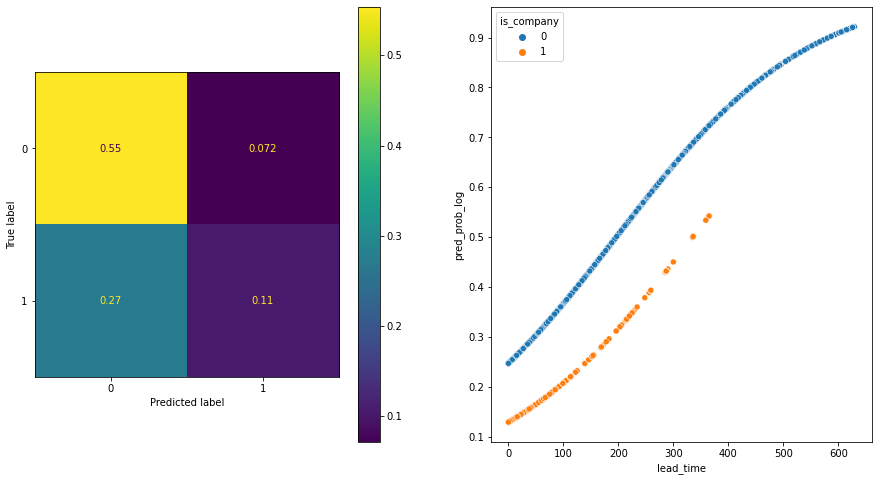

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (15, 8))
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot(ax = ax[0]);
sns.scatterplot(data = tb_test, x = 'lead_time', y = 'pred_prob_log', hue = 'is_company')
f1_score_test = f1_score(tb_test['is_cancelled'], tb_test['pred_log_is_cancelled'])
print(f"F1-Score: {f1_score_test}")


# kNN Classifier

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [27]:
knn_fit = KNeighborsClassifier(n_neighbors=5)
knn_fit.fit(X_train_sca, y_train)

KNeighborsClassifier()

In [28]:
tb_test['pred_knn_is_cancelled'] = knn_fit.predict(X_test_sca)
tb_test['pred_prob_knn'] = knn_fit.predict_proba(X_test_sca)[:,1]

F1-Score: 0.47918823773037894


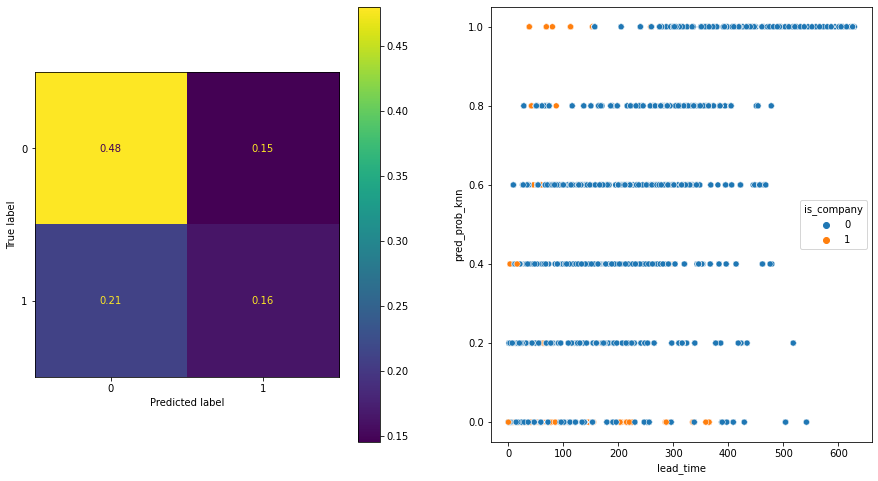

In [29]:
conf_mat = confusion_matrix(tb_test['is_cancelled'], tb_test['pred_knn_is_cancelled'], normalize = 'all')
fig, ax = plt.subplots(1, 2, figsize = (15, 8))
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot(ax = ax[0]);
sns.scatterplot(data = tb_test, x = 'lead_time', y = 'pred_prob_knn', hue = 'is_company')
f1_score_test = f1_score(tb_test['is_cancelled'], tb_test['pred_knn_is_cancelled'])
print(f"F1-Score: {f1_score_test}")


# Ensemble Methods

In [30]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import catboost as cat

In [32]:
cat_fit = cat.CatBoostClassifier(iterations=500, depth=3, od_type="Iter", 
                                 od_wait=50, verbose = False)
cat_fit.fit(X_train_sca, y_train, eval_set = (X_test_sca, y_test))

In [33]:
tb_test['pred_cat_is_cancelled'] = cat_fit.predict(X_test_sca)
tb_test['pred_prob_cat'] = cat_fit.predict_proba(X_test_sca)[:,1]

F1-Score: 0.38361439383879964


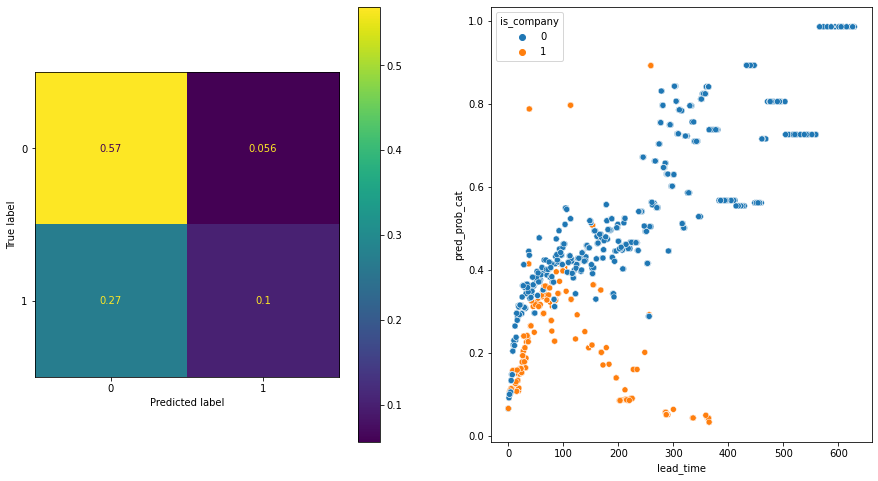

In [34]:
conf_mat = confusion_matrix(tb_test['is_cancelled'], tb_test['pred_cat_is_cancelled'], normalize = 'all')
fig, ax = plt.subplots(1, 2, figsize = (15, 8))
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot(ax = ax[0]);
sns.scatterplot(data = tb_test, x = 'lead_time', y = 'pred_prob_cat', hue = 'is_company')
f1_score_test = f1_score(tb_test['is_cancelled'], tb_test['pred_cat_is_cancelled'])
print(f"F1-Score: {f1_score_test}")


# Neural Networks

**Hyperparameters:**

1. `hidden_layer_sizes` tuple containing the number of neurons on each hidden layer;
1. `activation` string (‘identity’, ‘logistic’, ‘tanh’, ‘relu’) determining activation function of hidden layer. For a non-linear you must use either 'logistic', 'tanh' or 'relu';
1. `alpha` float - complexity penalization parameters;
1. `learning_rate` string ('constant' and 'adaptive') set the learning rate adaption strategy;


http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf

In [35]:
from sklearn.neural_network import MLPClassifier

In [36]:
relu_fit = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = 'relu')
relu_fit.fit(X_train_sca, y_train)

MLPClassifier(hidden_layer_sizes=(10, 10, 10))

In [37]:
tb_test['pred_relu_is_cancelled'] = relu_fit.predict(X_test_sca)
tb_test['pred_prob_relu'] = relu_fit.predict_proba(X_test_sca)[:,1]

F1-Score: 0.41407290783577566


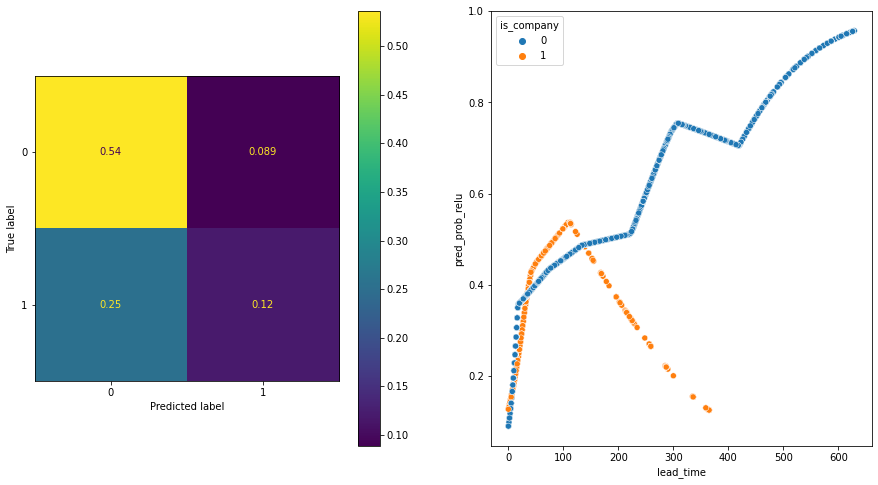

In [38]:
conf_mat = confusion_matrix(tb_test['is_cancelled'], tb_test['pred_relu_is_cancelled'], normalize = 'all')
fig, ax = plt.subplots(1, 2, figsize = (15, 8))
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot(ax = ax[0]);
sns.scatterplot(data = tb_test, x = 'lead_time', y = 'pred_prob_relu', hue = 'is_company')
f1_score_test = f1_score(tb_test['is_cancelled'], tb_test['pred_relu_is_cancelled'])
print(f"F1-Score: {f1_score_test}")


F1-Score: 0.33952328159645234


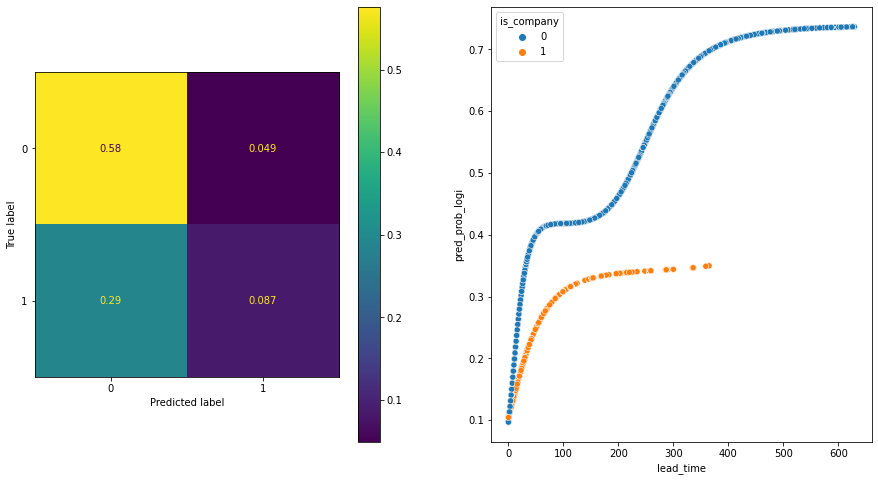

In [39]:
relu_fit = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = 'logistic')
relu_fit.fit(X_train_sca, y_train)

tb_test['pred_logi_is_cancelled'] = relu_fit.predict(X_test_sca)
tb_test['pred_prob_logi'] = relu_fit.predict_proba(X_test_sca)[:,1]

conf_mat = confusion_matrix(tb_test['is_cancelled'], tb_test['pred_logi_is_cancelled'], normalize = 'all')
fig, ax = plt.subplots(1, 2, figsize = (15, 8))
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot(ax = ax[0]);
sns.scatterplot(data = tb_test, x = 'lead_time', y = 'pred_prob_logi', hue = 'is_company')
f1_score_test = f1_score(tb_test['is_cancelled'], tb_test['pred_logi_is_cancelled'])
print(f"F1-Score: {f1_score_test}")


## Optimizing MLP Classifiers

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters = {'hidden_layer_sizes' : [(10, 10, 10), (50, 50), (5, 5, 5, 5), (100)],
              'activation' : ['relu', 'tanh', 'logistic'],
              'alpha' : np.linspace(0.00001, 0.01, 10),
              'learning_rate' : ['constant', 'adaptive']}

nn_fit = MLPClassifier()
cv_nn_fit = GridSearchCV(nn_fit, parameters, n_jobs = -1)
cv_nn_fit.fit(X_train_sca, y_train)

In [ ]:
tb_test['pred_nn_is_cancelled'] = nn_fit.predict(X_test_sca)
tb_test['pred_prob_nn'] = nn_fit.predict_proba(X_test_sca)[:,1]

conf_mat = confusion_matrix(tb_test['is_cancelled'], tb_test['pred_nn_is_cancelled'], normalize = 'all')
fig, ax = plt.subplots(1, 2, figsize = (15, 8))
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot(ax = ax[0]);
sns.scatterplot(data = tb_test, x = 'lead_time', y = 'pred_prob_nn', hue = 'is_company')
f1_score_test = f1_score(tb_test['is_cancelled'], tb_test['pred_nn_is_cancelled'])
print(f"F1-Score: {f1_score_test}")